In [1]:
import numpy as np
from astropy.io import fits
import astropy.units as u
import astropy.constants as const
import matplotlib.pyplot as plt
from matplotlib.cm import register_cmap
import astropy.units as u
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from astropy.wcs import WCS
from scipy import ndimage as ndi
from astropy.visualization import ImageNormalize, ZScaleInterval
from mpl_toolkits.axes_grid1 import make_axes_locatable
import tensorflow as tf
import skimage.measure as skmeas
from os import listdir
import paramiko
from skimage.util.shape import view_as_windows
from spectral_cube import SpectralCube
import os
import gc
import pickle
import sys
sys.path.insert(0,'..')
from data_generators.cube_functions import *

## Load in cubes

In [2]:
[i for i in listdir("../data/training/Target")if ".fits" in i]

['mask_1245mosC.fits']

In [3]:
cube_hdulist = fits.open("../data/training/Input/noisefree_1245mosC.fits")
cube_data = cube_hdulist[0].data
cube_hdulist.close()

maskcube_hdulist = fits.open("../data/training/Target/mask_1245mosC.fits")
maskcube_data = maskcube_hdulist[0].data
maskcube_hdulist.close()

FileNotFoundError: [Errno 2] No such file or directory: '../data/training/Input/noisefree_1245mosC.fits'

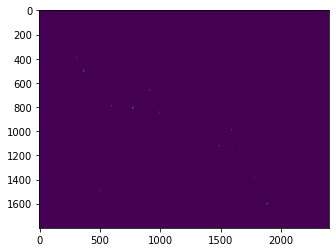

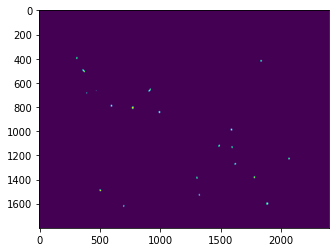

In [5]:
plt.imshow(cube_data[300, :, :])
plt.show()
plt.imshow(maskcube_data[300, :, :])
plt.show()

# Sanity check for sliding window

In [ ]:
import nibabel as nib
n1_img = nib.load('../nsM00587_0002.hdr').get_fdata()
n1_img.shape

In [ ]:
from skimage.util.shape import view_as_windows

kernel=(78, 94, 34)
stride=(78, 94, 34)
subvols = view_as_windows(n1_img, kernel, stride)
x,y,z = subvols.shape[:3]
sx, sy, sz = kernel
subvols = tf.reshape(subvols,[x*y*z,sx,sy,sz])
subvols.shape

In [ ]:
for i in range(1, len(subvols)):
    plt.imshow(subvols[i][:, :, 0])
    plt.show()

## Test sliding window

In [354]:
cube_hdulist = fits.open("../Target/mask_0.fits")
cube_data = cube_hdulist[0].data
cube_hdulist.close()
cube_data.shape

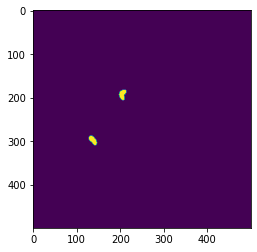

In [89]:
reshaped = np.moveaxis(maskcube_data[:300, :500, :500], 0, 2)
plt.imshow(reshaped[:, :, 200])

In [20]:
from skimage.util.shape import view_as_windows

kernel=(128, 128, 64)
stride=np.array(kernel) - np.array((15, 20, 20))
subvols = view_as_windows(reshaped, kernel, stride)
x,y,z = subvols.shape[:3]
sx, sy, sz = kernel
subvols = tf.reshape(subvols,[x*y*z,sx,sy,sz])
print(len(subvols), subvols[0].shape)

96 (128, 128, 64)


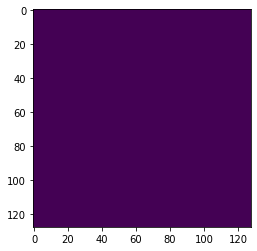

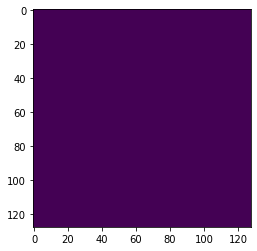

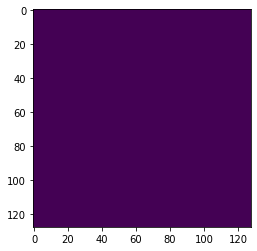

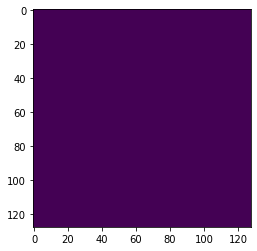

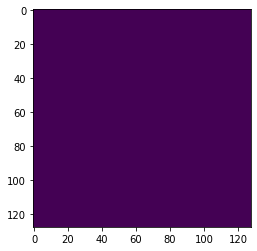

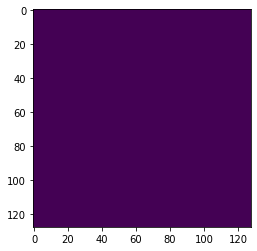

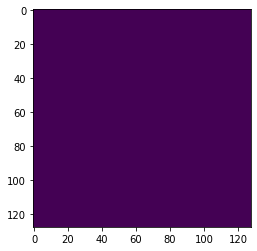

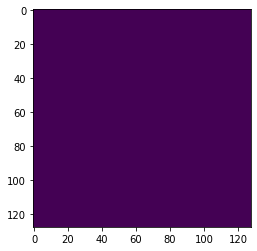

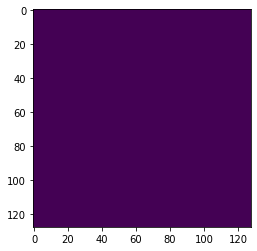

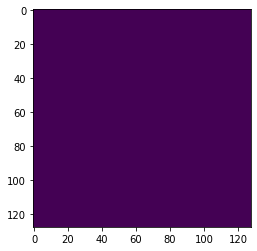

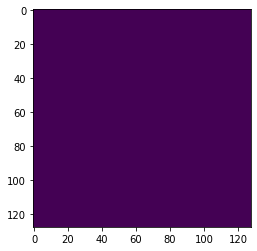

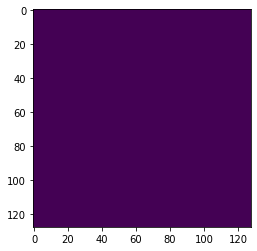

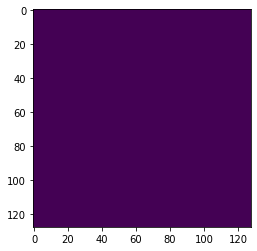

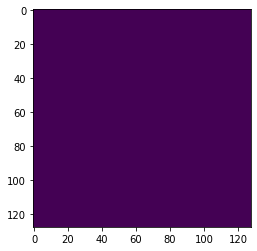

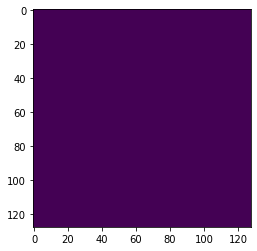

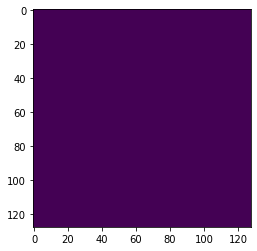

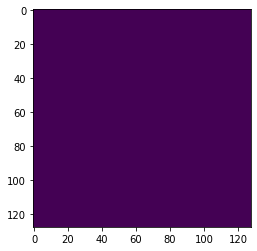

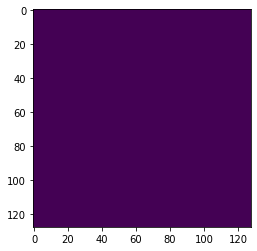

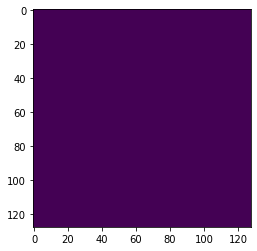

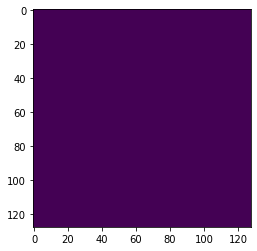

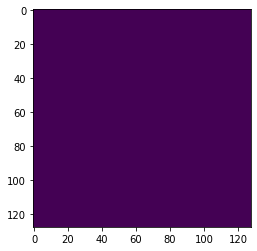

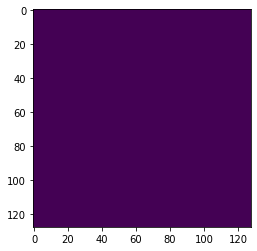

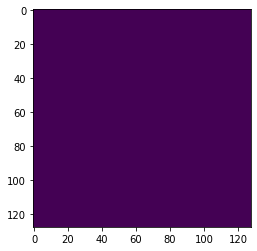

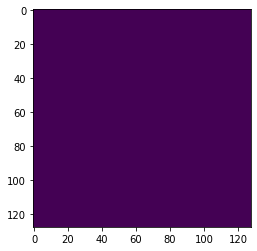

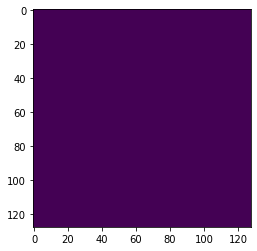

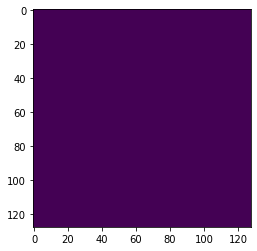

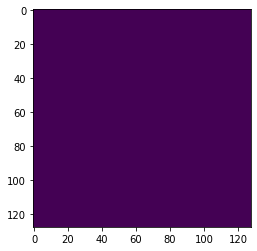

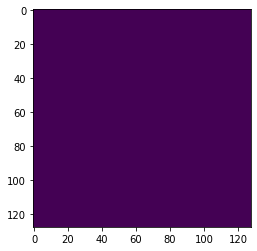

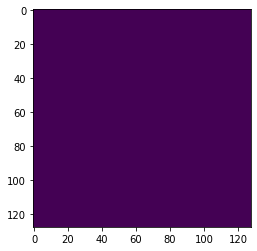

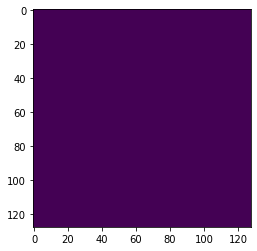

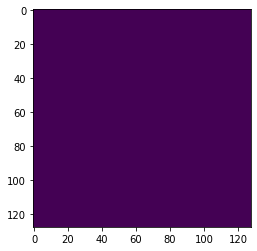

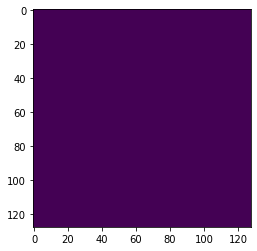

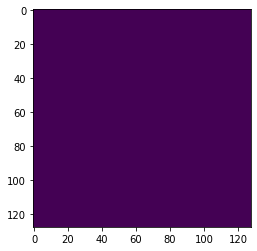

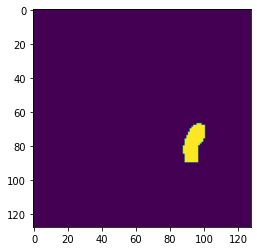

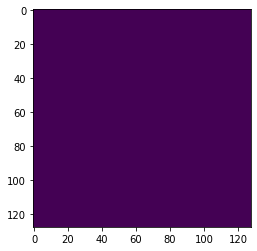

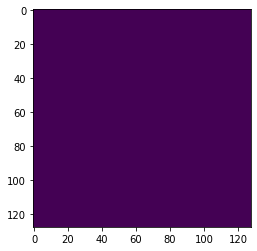

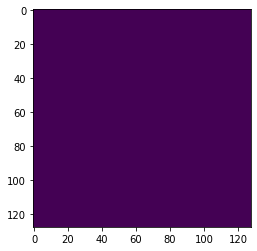

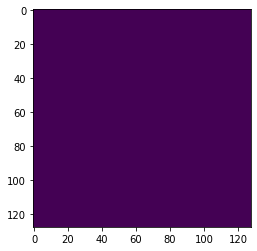

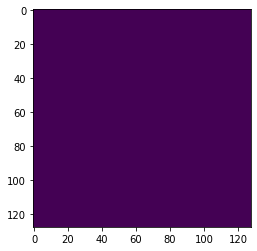

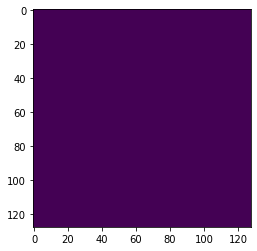

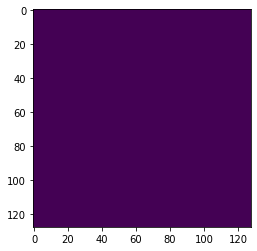

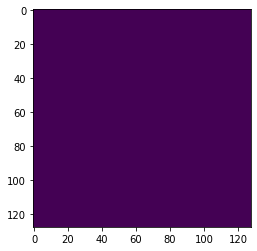

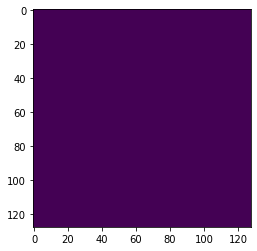

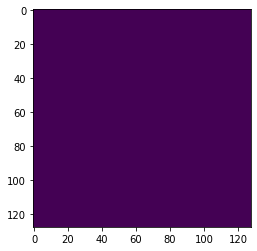

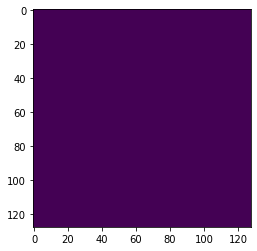

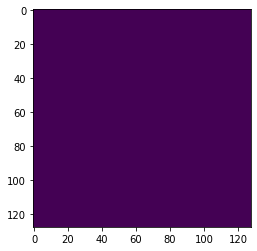

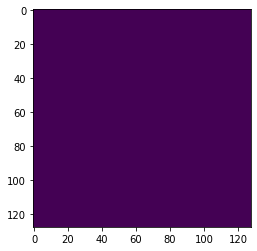

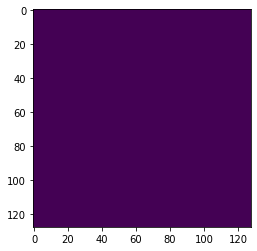

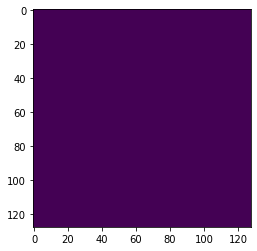

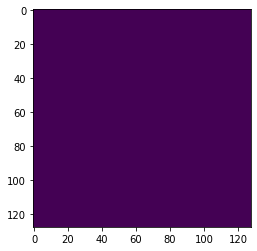

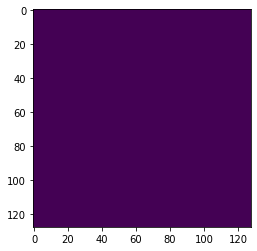

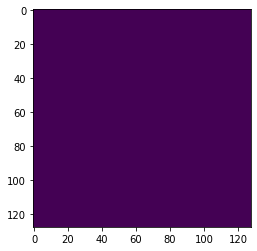

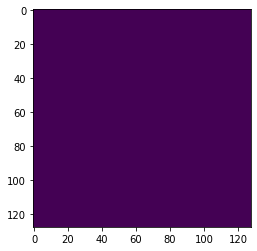

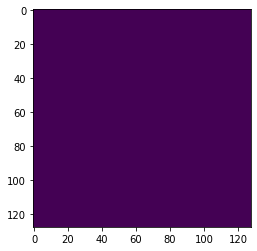

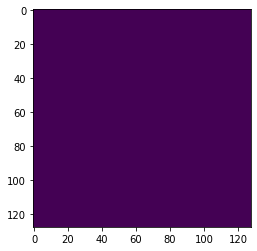

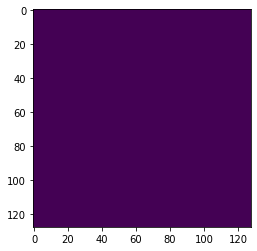

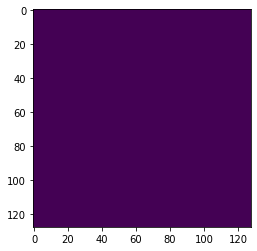

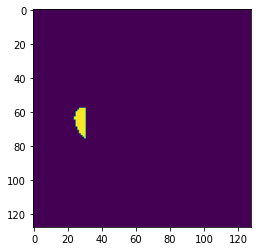

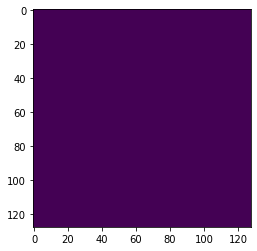

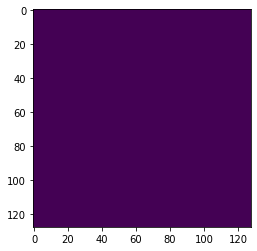

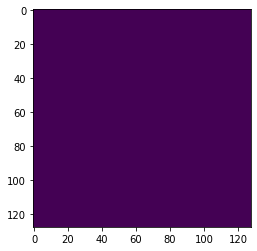

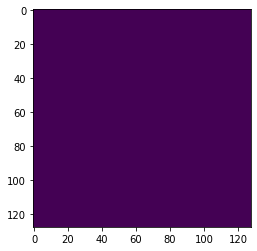

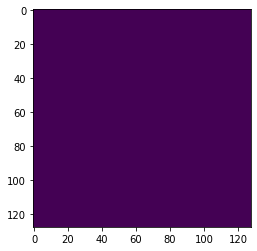

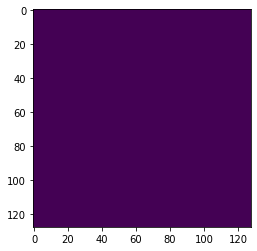

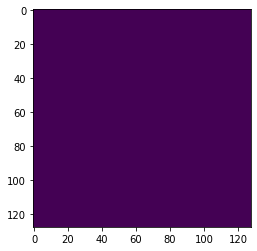

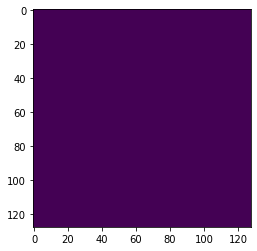

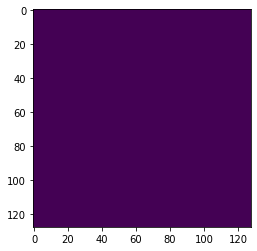

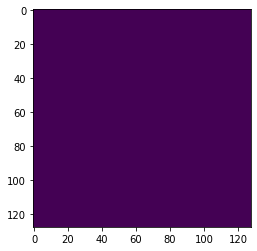

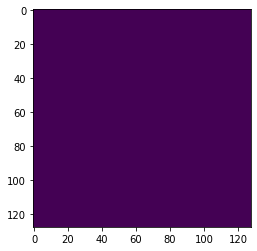

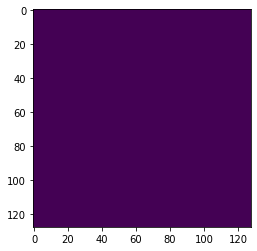

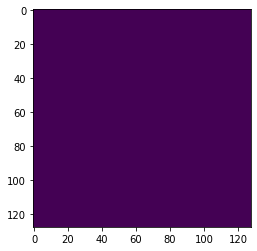

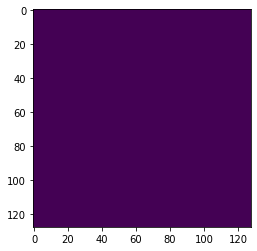

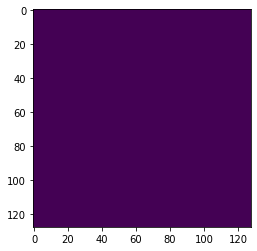

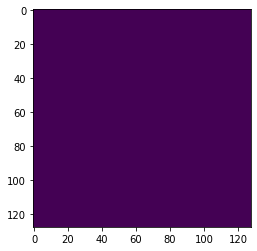

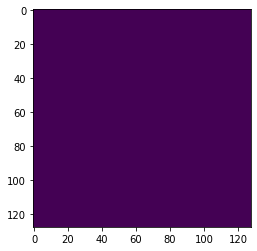

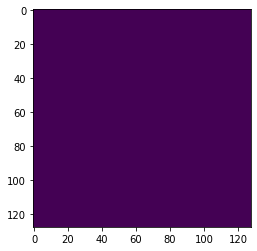

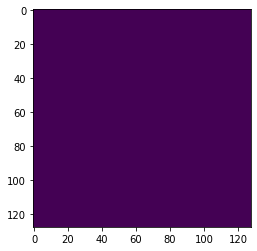

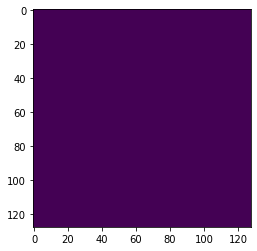

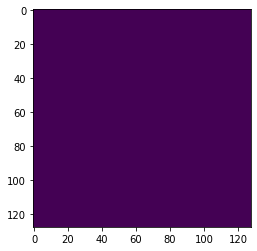

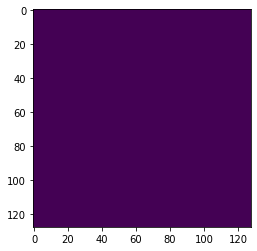

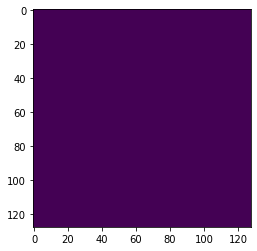

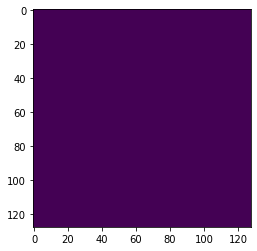

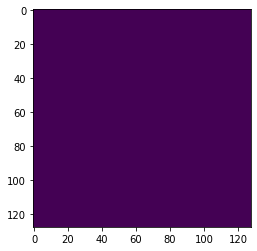

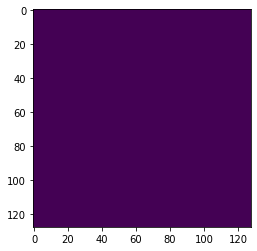

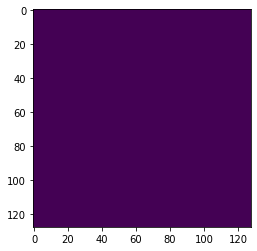

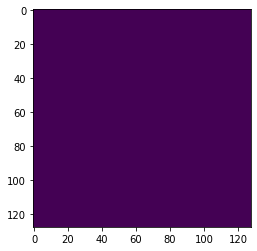

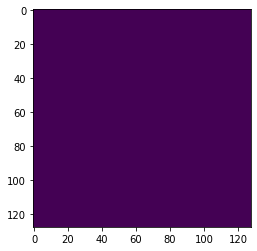

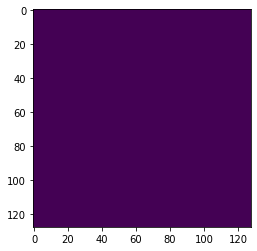

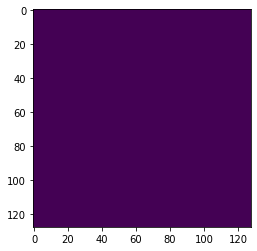

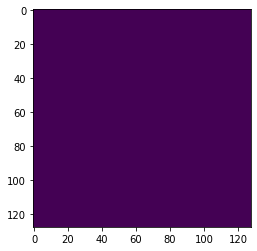

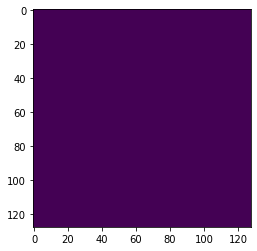

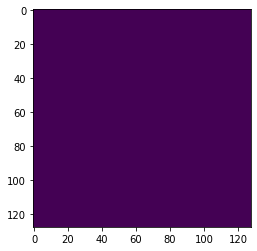

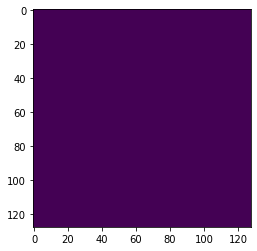

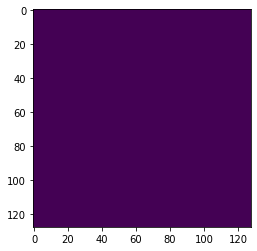

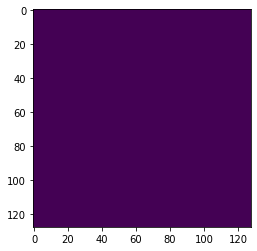

In [21]:
for i in range(1, len(subvols)):
    plt.imshow(subvols[i][:, :, 30])
    plt.show()

## Dimensions of galaxies
- [x] Volume
- [x] Total Flux
- [x] Peak Flux
- [x] Eccentricity
- [x] Flatness

### 1. First test with tiny cube with two galaxies

In [355]:
test_mask = maskcube_data[195:205, :500, :500]
test_subcube = cube_data[195:205, :500, :500]
new_mask = test_mask > 0
object_labels = skmeas.label(new_mask)

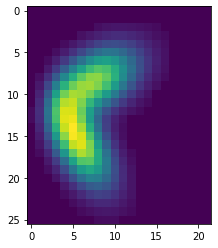

Eccentricity = 1.3186422460924205
Flatness = 1.6586410582123614
Dimensions =  (10, 26, 22)
Volume =  5720
Total Flux =  0.41890385464299473
Peak Flux =  0.004320765342563391


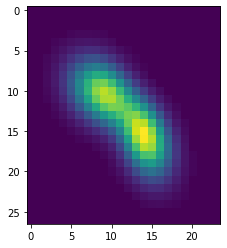

Eccentricity = 1.3855970581368249
Flatness = 1.6686376610259082
Dimensions =  (10, 27, 24)
Volume =  6480
Total Flux =  0.36448865704180206
Peak Flux =  0.0036930414009839294

Percentage of cube =  0.488 %


In [127]:
some_props = skmeas.regionprops(object_labels)
gal_list = []
for i in range(len(some_props)):
    bb = some_props[i].bbox
    where_gal = test_subcube[bb[0]:bb[3], bb[1]:bb[4], bb[2]:bb[5]]
    flux = np.sum(where_gal)
    peak_flux = np.max(np.sum(where_gal, axis=0))
    plt.imshow(test_subcube[int((bb[3] - bb[0])/2), bb[1]:bb[4], bb[2]:bb[5]])
    plt.show()
    gal_list.append(where_gal)
    eigen_vals = some_props[i].inertia_tensor_eigvals
    eccentricity = eigen_vals[0]/eigen_vals[1]
    flatness = eigen_vals[1]/eigen_vals[2]
    galdims = some_props[i].image.shape
    vol = np.prod(galdims)
    print("Eccentricity =", eccentricity)
    print("Flatness =", flatness)
    print("Dimensions = ", galdims)
    print("Volume = ", vol)
    print("Total Flux = ", flux)
    print("Peak Flux = ", peak_flux)

vols = [np.prod(i.image.shape) for i in some_props]    
pixel_percent = np.sum(vols)/np.prod(test_mask.shape)
print()
print("Percentage of cube = ", pixel_percent*100, "%")

### 2. Apply to whole cube

In [9]:
new_mask = maskcube_data > 0
object_labels = skmeas.label(new_mask)

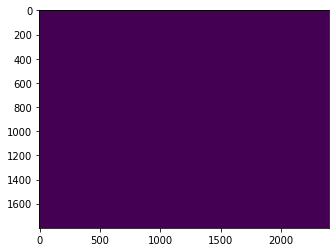

In [10]:
plt.imshow(object_labels[5])

In [11]:
some_props = skmeas.regionprops(object_labels)

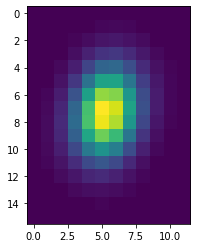

Eccentricity = 1.0563452633241044
Flatness = 5.921171441326793
Dimensions =  (36, 16, 12)
Volume =  6912
Total Flux =  0.04157509620516066
Peak/ Flux =  0.0016133659768092915


In [150]:
i = 0
bb = some_props[i].bbox
where_gal = cube_data[bb[0]:bb[3], bb[1]:bb[4], bb[2]:bb[5]]
flux = np.sum(where_gal)
peak_flux = np.max(np.sum(where_gal, axis=0))
plt.imshow(where_gal[int((bb[3] - bb[0])/2)])
plt.show()
eigen_vals = some_props[i].inertia_tensor_eigvals
eccentricity = eigen_vals[0]/eigen_vals[1]
flatness = eigen_vals[1]/eigen_vals[2]
galdims = some_props[i].image.shape
vol = np.prod(galdims)
print("Eccentricity =", eccentricity)
print("Flatness =", flatness)
print("Dimensions = ", galdims)
print("Volume = ", vol)
print("Total Flux = ", flux)
print("Peak/ Flux = ", peak_flux)

In [161]:
bbs = [gal.bbox for gal in some_props]
tot_fluxes = [np.sum(cube_data[bbs[i][0]:bbs[i][3], bbs[i][1]:bbs[i][4], bbs[i][2]:bbs[i][5]])
     for i in range(len(some_props))]
peak_fluxes = [np.max(np.sum(cube_data[bbs[i][0]:bbs[i][3], bbs[i][1]:bbs[i][4], bbs[i][2]:bbs[i][5]], axis=0))
     for i in range(len(some_props))]
eigen_vals = [gal.inertia_tensor_eigvals for gal in some_props]
eccentricities = [e[0]/e[1] for e in eigen_vals]
flatnesses = [e[1]/e[2] for e in eigen_vals]
galdims = [gal.image.shape for gal in some_props]
vols = [np.prod(gal) for gal in galdims]
pixel_percent = np.sum(vols)/np.prod(cube_data.shape)

   
print()
print("Percentage of cube = ", pixel_percent*100, "%")


Percentage of cube =  0.15552942513065213 %


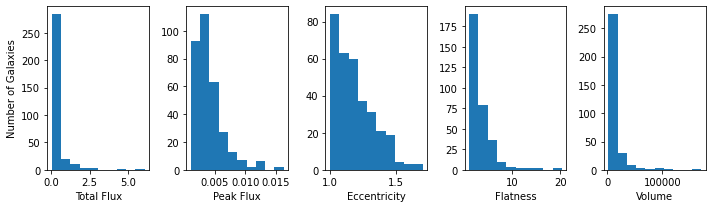

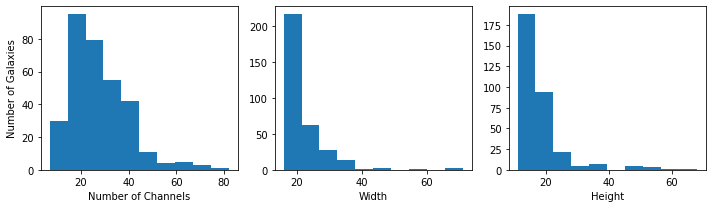

In [168]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(10,3))
ax1.hist(tot_fluxes)
ax2.hist(peak_fluxes)
ax3.hist(eccentricities)
ax4.hist(flatnesses)
ax5.hist(vols)
ax1.set_ylabel("Number of Galaxies")
ax1.set_xlabel("Total Flux")
ax2.set_xlabel("Peak Flux")
ax3.set_xlabel("Eccentricity")
ax4.set_xlabel("Flatness")
ax5.set_xlabel("Volume")
fig.tight_layout()
plt.show()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,3))
ax1.hist([i[0] for i in galdims])
ax2.hist([i[1] for i in galdims])
ax3.hist([i[2] for i in galdims])
ax1.set_xlabel("Number of Channels")
ax2.set_xlabel("Width")
ax3.set_xlabel("Height")
ax1.set_ylabel("Number of Galaxies")
fig.tight_layout()
plt.show()

## Summary results for all 14 cubes (ran with seperate script)

In [26]:
import pickle
with open("../data_generators/cube_summaries/eccentricity.txt", "rb") as fp:
    eccentricity = pickle.load(fp)
with open("../data_generators/cube_summaries/flatness.txt", "rb") as fp:
    flatness = pickle.load(fp)
with open("../data_generators/cube_summaries/vol.txt", "rb") as fp:
    vol = pickle.load(fp)
with open("../data_generators/cube_summaries/galdim.txt", "rb") as fp:
    galdim = pickle.load(fp)
with open("../data_generators/cube_summaries/tot_flux.txt", "rb") as fp:
    tot_flux = pickle.load(fp)
with open("../data_generators/cube_summaries/peak_flux.txt", "rb") as fp:
    peak_flux = pickle.load(fp)
with open("../data_generators/cube_summaries/voxel_percents.txt", "rb") as fp:
    pixel_percents = pickle.load(fp)

In [9]:
freq_dict = {"mask_1245mosB.fits": [1401252439.970,1425092772.001],
"mask_1245mosC.fits": [1381037599.970,1404877932.001],
"mask_1245mosD.fits": [1360822751.970,1384663084.001],
"mask_1245mosE.fits": [1340607911.970,1364448244.001],
"mask_1245mosF.fits": [1320393067.970,1344233400.001],
"mask_1245mosG.fits": [1300178221.970,1324018554.001],
"mask_1245mosH.fits": [1279963378.910,1303803710.941],
"mask_1353mosB.fits": [1401179199.970,1425019532.001],
"mask_1353mosC.fits": [1380964351.970,1404804684.001],
"mask_1353mosD.fits": [1360749511.970,1384589844.001],
"mask_1353mosE.fits": [1340534667.970,1364375000.001],
"mask_1353mosF.fits": [1320319823.970,1344160156.001],
"mask_1353mosG.fits": [1300104979.970,1323945312.001],
"mask_1353mosH.fits": [1279890136.720,1303730468.751]}

In [63]:
import pandas as pd
d_width = 0.001666666707*u.deg
mask_cat_df = pd.read_csv("../results/loud_MASK_catalog.txt", index_col=0)
mask_cat_df["mos_name"] = mask_cat_df.file.str.replace(".fits", "").str.split("_", expand=True)[1]
mask_cat_df["nx_mpc"] = mask_cat_df.dist*np.tan(np.deg2rad(d_width*mask_cat_df.nx))
mask_cat_df["ny_mpc"] = mask_cat_df.dist*np.tan(np.deg2rad(d_width*mask_cat_df.ny))
mask_cat_df['start_freq'] = ("mask_" + mask_cat_df.mos_name + ".fits").map({i: k[0] for i, k in freq_dict.items()})

<ipython-input-63-c5f0392f3547>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  mask_cat_df["mos_name"] = mask_cat_df.file.str.replace(".fits", "").str.split("_", expand=True)[1]


In [27]:
freq_axis_1353 = [freq_dict[i[0]] for i in eccentricity if "mask_1353" in i[0]]
freq_axis_1245 = [freq_dict[i[0]] for i in eccentricity if "mask_1245" in i[0]]
freq_ticks = [float(i[0]) for i in freq_axis_1353]
mask_1353_idx = [idx for idx, element in enumerate(eccentricity) if "mask_1353" in element[0]]
mask_1245_idx = [idx for idx, element in enumerate(eccentricity) if "mask_1245" in element[0]]

df_1353 = pd.DataFrame(freq_axis_1353, columns=[["freq_1", "freq_2"]])
df_1353.columns = df_1353.columns.map(''.join)
df_1353['freq_labels'] = np.round(df_1353['freq_1']*1e-6, 2).astype(str) + "-" + np.round(df_1353['freq_2']*1e-6).astype(int).astype(str)
df_1353["mean_eccentricity"] = [np.mean(i[1:]) for i in eccentricity if "mask_1353" in i[0]]
df_1353["mean_flatness"] = [np.mean(i[1:]) for i in flatness if "mask_1353" in i[0]]
df_1353["mean_vol"] = [np.mean(i[1:]) for i in vol if "mask_1353" in i[0]]
df_1353["mean_peak_flux"] = [np.mean(i[1:]) for i in peak_flux if "mask_1353" in i[0]]
df_1353["mean_tot_flux"] = [np.mean(i[1:]) for i in tot_flux if "mask_1353" in i[0]]
df_1353["pixel_percents"] = [i[1]*100 for i in pixel_percents if "mask_1353" in i[0]]
df_1353["num_gal"] = [len(i[1:])for i in eccentricity if "mask_1353" in i[0]]
df_1353["mean_gal_dim0"] = [np.mean([dim[0] for dim in galdim[i]]) for i in mask_1353_idx]
df_1353["mean_gal_dim1"] = [np.mean([dim[1] for dim in galdim[i]]) for i in mask_1353_idx]
df_1353["mean_gal_dim2"] = [np.mean([dim[2] for dim in galdim[i]]) for i in mask_1353_idx]
df_1353 = df_1353.sort_values('freq_1')

df_1245 = pd.DataFrame(freq_axis_1245, columns=[["freq_1", "freq_2"]])
df_1245.columns = df_1245.columns.map(''.join)
df_1245['freq_labels'] = np.round(df_1245['freq_1']*1e-6, 2).astype(str) + "-" + np.round(df_1245['freq_2']*1e-6).astype(int).astype(str)
df_1245["mean_eccentricity"] = [np.mean(i[1:]) for i in eccentricity if "mask_1245" in i[0]]
df_1245["mean_flatness"] = [np.mean(i[1:]) for i in flatness if "mask_1245" in i[0]]
df_1245["mean_vol"] = [np.mean(i[1:]) for i in vol if "mask_1245" in i[0]]
df_1245["mean_peak_flux"] = [np.mean(i[1:]) for i in peak_flux if "mask_1245" in i[0]]
df_1245["mean_tot_flux"] = [np.mean(i[1:]) for i in tot_flux if "mask_1245" in i[0]]
df_1245["pixel_percents"] = [i[1]*100 for i in pixel_percents if "mask_1245" in i[0]]
df_1245["num_gal"] = [len(i[1:])for i in eccentricity if "mask_1245" in i[0]]
df_1245["mean_gal_dim0"] = [np.mean([dim[0] for dim in galdim[i]]) for i in mask_1245_idx]
df_1245["mean_gal_dim1"] = [np.mean([dim[1] for dim in galdim[i]]) for i in mask_1245_idx]
df_1245["mean_gal_dim2"] = [np.mean([dim[2] for dim in galdim[i]]) for i in mask_1245_idx]
df_1245 = df_1245.sort_values('freq_1')

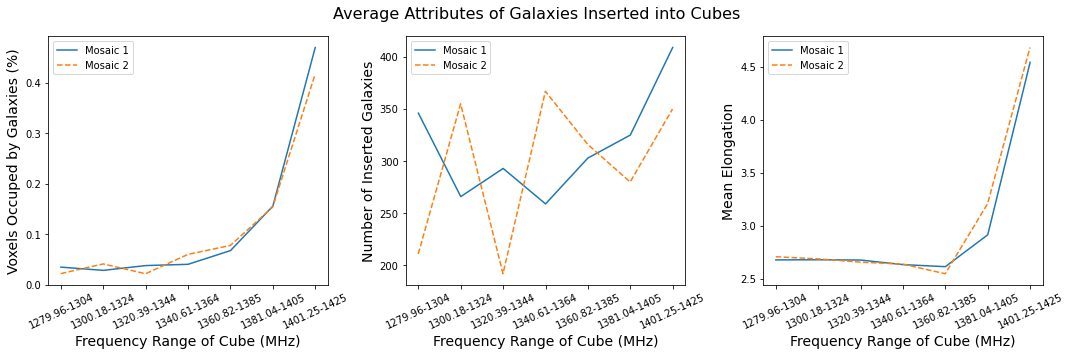

In [67]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
fig.suptitle("Average Attributes of Galaxies Inserted into Cubes", fontsize=16)
ax1.set_xlabel(r"Frequency Range of Cube (MHz)", fontsize=14)
ax1.set_xticks(ticks=df_1245.freq_1)
ax1.set_xticklabels(df_1245.freq_labels, rotation=25)
ax1.set_ylabel("Voxels Occuped by Galaxies (%)", fontsize=14)
ax1.plot(df_1245.freq_1, df_1245.pixel_percents, label="Mosaic 1")
ax1.plot(df_1353.freq_1, df_1353.pixel_percents, label="Mosaic 2", linestyle="--")
ax1.legend()

ax2.set_ylabel('Number of Inserted Galaxies', fontsize=14)
ax2.plot(df_1245.freq_1, df_1245.num_gal, label="Mosaic 1")
ax2.plot(df_1353.freq_1, df_1353.num_gal, label="Mosaic 2", linestyle="--")
ax2.set_xlabel(r"Frequency Range of Cube (MHz)", fontsize=14)
ax2.set_xticks(ticks=df_1245.freq_1)
ax2.set_xticklabels(df_1245.freq_labels, rotation=25)
ax2.legend()

# mask_cat_df.groupby("start_freq").elongation.mean()

ax3.set_xlabel(r"Frequency Range of Cube (MHz)", fontsize=14)
ax3.set_xticks(ticks=df_1245.freq_1)
ax3.set_xticklabels(df_1245.freq_labels, rotation=25)
ax3.set_ylabel("Mean Elongation", fontsize=14)
ax3.plot(mask_cat_df[mask_cat_df.mos_name.str.contains("1245")].groupby('start_freq').elongation.mean(), label="Mosaic 1")
ax3.plot(mask_cat_df[mask_cat_df.mos_name.str.contains("1353")].groupby('start_freq').elongation.mean(), label="Mosaic 2", linestyle="--")
ax3.legend()


fig.tight_layout()
plt.show()

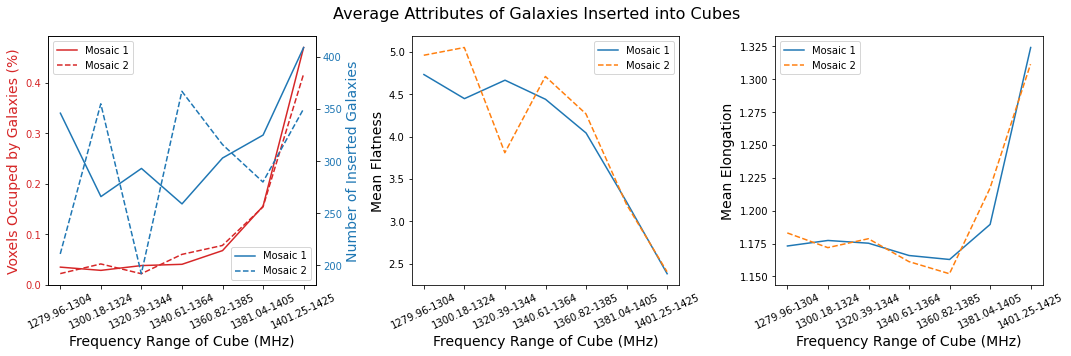

In [28]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
fig.suptitle("Average Attributes of Galaxies Inserted into Cubes", fontsize=16)
color = 'tab:red'
ax1.set_xlabel(r"Frequency Range of Cube (MHz)", fontsize=14)
ax1.set_xticks(ticks=df_1245.freq_1)
ax1.set_xticklabels(df_1245.freq_labels, rotation=25)
ax1.set_ylabel("Voxels Occuped by Galaxies (%)", color=color, fontsize=14)
ax1.plot(df_1245.freq_1, df_1245.pixel_percents, color=color, label="Mosaic 1")
ax1.plot(df_1353.freq_1, df_1353.pixel_percents, color=color, label="Mosaic 2", linestyle="--")
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend()
ax4 = ax1.twinx()

color = 'tab:blue'
ax4.set_ylabel('Number of Inserted Galaxies', color=color, fontsize=14)
ax4.plot(df_1245.freq_1, df_1245.num_gal, color=color, label="Mosaic 1")
ax4.plot(df_1353.freq_1, df_1353.num_gal, color=color, label="Mosaic 2", linestyle="--")
ax4.tick_params(axis='y', labelcolor=color)
ax4.legend(loc="lower right")

ax2.set_xlabel(r"Frequency Range of Cube (MHz)", fontsize=14)
ax2.set_xticks(ticks=df_1245.freq_1)
ax2.set_xticklabels(df_1245.freq_labels, rotation=25)
ax2.set_ylabel("Mean Flatness", fontsize=14)
ax2.plot(df_1245.freq_1, df_1245.mean_flatness, label="Mosaic 1")
ax2.plot(df_1353.freq_1, df_1353.mean_flatness, label="Mosaic 2", linestyle="--")
ax2.tick_params(axis='y')
ax2.legend()

ax3.set_xlabel(r"Frequency Range of Cube (MHz)", fontsize=14)
ax3.set_xticks(ticks=df_1245.freq_1)
ax3.set_xticklabels(df_1245.freq_labels, rotation=25)
ax3.set_ylabel("Mean Elongation", fontsize=14)
ax3.plot(df_1245.freq_1, df_1245.mean_eccentricity, label="Mosaic 1")
ax3.plot(df_1353.freq_1, df_1353.mean_eccentricity, label="Mosaic 2", linestyle="--")
ax3.tick_params(axis='y')
ax3.legend()


fig.tight_layout()
plt.show()

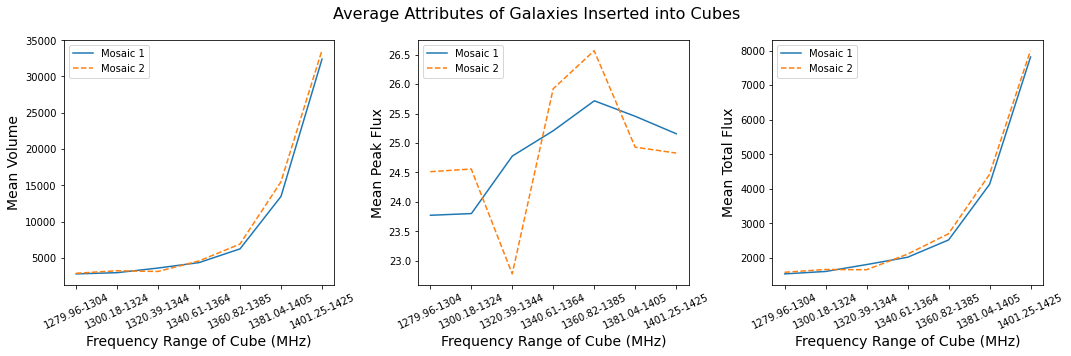

In [198]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))

fig.suptitle("Average Attributes of Galaxies Inserted into Cubes", fontsize=16)
ax1.set_xlabel(r"Frequency Range of Cube (MHz)", fontsize=14)
ax1.set_xticks(ticks=df_1245.freq_1)
ax1.set_xticklabels(df_1245.freq_labels, rotation=25)
ax1.set_ylabel("Mean Volume", fontsize=14)
ax1.plot(df_1245.freq_1, df_1245.mean_vol, label="Mosaic 1")
ax1.plot(df_1353.freq_1, df_1353.mean_vol, label="Mosaic 2", linestyle="--")
ax1.tick_params(axis='y')
ax1.legend()

ax2.set_xlabel(r"Frequency Range of Cube (MHz)", fontsize=14)
ax2.set_xticks(ticks=df_1245.freq_1)
ax2.set_xticklabels(df_1245.freq_labels, rotation=25)
ax2.set_ylabel("Mean Peak Flux", fontsize=14)
ax2.plot(df_1245.freq_1, df_1245.mean_peak_flux, label="Mosaic 1")
ax2.plot(df_1353.freq_1, df_1353.mean_peak_flux, label="Mosaic 2", linestyle="--")
ax2.tick_params(axis='y')
ax2.legend()

ax3.set_xlabel(r"Frequency Range of Cube (MHz)", fontsize=14)
ax3.set_xticks(ticks=df_1245.freq_1)
ax3.set_xticklabels(df_1245.freq_labels, rotation=25)
ax3.set_ylabel("Mean Total Flux", fontsize=14)
ax3.plot(df_1245.freq_1, df_1245.mean_tot_flux, label="Mosaic 1")
ax3.plot(df_1353.freq_1, df_1353.mean_tot_flux, label="Mosaic 2", linestyle="--")
ax3.tick_params(axis='y')
ax3.legend()


fig.tight_layout()
plt.show()

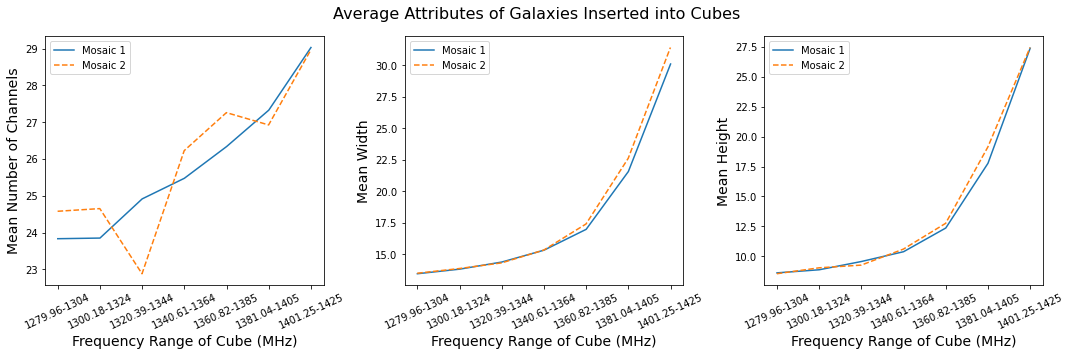

In [199]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))

fig.suptitle("Average Attributes of Galaxies Inserted into Cubes", fontsize=16)
ax1.set_xlabel(r"Frequency Range of Cube (MHz)", fontsize=14)
ax1.set_xticks(ticks=df_1245.freq_1)
ax1.set_xticklabels(df_1245.freq_labels, rotation=25)
ax1.set_ylabel("Mean Number of Channels", fontsize=14)
ax1.plot(df_1245.freq_1, df_1245.mean_gal_dim0, label="Mosaic 1")
ax1.plot(df_1353.freq_1, df_1353.mean_gal_dim0, label="Mosaic 2", linestyle="--")
ax1.tick_params(axis='y')
ax1.legend()

ax2.set_xlabel(r"Frequency Range of Cube (MHz)", fontsize=14)
ax2.set_xticks(ticks=df_1245.freq_1)
ax2.set_xticklabels(df_1245.freq_labels, rotation=25)
ax2.set_ylabel("Mean Width", fontsize=14)
ax2.plot(df_1245.freq_1, df_1245.mean_gal_dim1, label="Mosaic 1")
ax2.plot(df_1353.freq_1, df_1353.mean_gal_dim1, label="Mosaic 2", linestyle="--")
ax2.tick_params(axis='y')
ax2.legend()

ax3.set_xlabel(r"Frequency Range of Cube (MHz)", fontsize=14)
ax3.set_xticks(ticks=df_1245.freq_1)
ax3.set_xticklabels(df_1245.freq_labels, rotation=25)
ax3.set_ylabel("Mean Height", fontsize=14)
ax3.plot(df_1245.freq_1, df_1245.mean_gal_dim2, label="Mosaic 1")
ax3.plot(df_1353.freq_1, df_1353.mean_gal_dim2, label="Mosaic 2", linestyle="--")
ax3.tick_params(axis='y')
ax3.legend()


fig.tight_layout()
plt.show()

## Do Same for noise cubes

In [389]:
orig_d = 50*u.Mpc
h_0 = 70*u.km/(u.Mpc*u.s)
noise_res = [15*u.arcsec, 25*u.arcsec]
filename = "../data/mock_gals/model1000.fits"
orig_mass, dx, dy, dF, rest_freq, orig_scale, gal_data = load_cube(filename, orig_d, h_0)
noise_cube_hdulist = fits.open("../data/mosaics/1245mosC.derip.norm.fits")
noise_cube_hdulist[0].header['CTYPE3'] = 'FREQ'
noise_cube_hdulist[0].header['CUNIT3'] = 'Hz'
noise_cube = SpectralCube.read(noise_cube_hdulist)
noise_data = noise_cube.unmasked_data[:, :, :].value
noise_header = noise_cube.header
noise_spectral = noise_cube.spectral_axis
noise_cube_hdulist.close()
chosen_f, new_z, new_dist, z_pos = choose_freq(
    noise_spectral, noise_data.shape, gal_data.shape, rest_freq, h_0, orig_d)
smoothed_gal = smooth_cube(noise_res, new_z, new_dist, dx, dy, gal_data, orig_scale)
resampled, new_dF = regrid_cube(smoothed_gal, noise_header, new_dist, dx, dy, dF, orig_scale, chosen_f, rest_freq)
scaled_flux = rescale_cube(resampled, noise_header, orig_d, rest_freq, new_dist, h_0, new_z, orig_mass, new_dF)

In [314]:
def Gauss(x, a, x0, sigma):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2))

def two_gaussians(x, h1, c1, w1, h2, c2, w2):
    return Gauss(x, h1, c1, w1) + Gauss(x, h2, c2, w2)

def fit_gauss(subcube, ax):
    x = np.arange(subcube.shape[2])
    y = [np.nansum(subcube[..., k]) for k in range(subcube.shape[2])]
    ax.plot(x, y, 'b+:', label='data')
    try:
        # weighted arithmetic mean (corrected - check the section below)
        peaks, properties = find_peaks(y, distance=25)
        peak_x = [x[y == sorted(np.array(y)[peaks])[-2:][0]][0], x[y == sorted(np.array(y)[peaks])[-2:][1]][0]]
        peak_y = sorted(np.array(y)[peaks])[-2:]
        sigma1 = np.sqrt(sum(y * (x - peak_x[0])**2) / sum(y))
        sigma2 = np.sqrt(sum(y * (x - peak_x[1])**2) / sum(y))
        popt, pcov = curve_fit(two_gaussians, x, y, p0=[
            peak_y[0], peak_x[0], sigma1,
            peak_y[1], peak_x[1], sigma2])
        residuals = y- two_gaussians(x, *popt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y-np.mean(y))**2)
        r_squared = 1 - (ss_res / ss_tot)
        ax.plot(x, two_gaussians(x, *popt), 'g-', label='fit')
    except:
        r_squared = np.nan
    ax.set_title(r"R$^2$=%s"%np.round(r_squared, 2))
    ax.set_ylabel("Total Flux")
#     print(r_squared)
    return

In [553]:
masked_bin = (scaled_flux > np.mean(scaled_flux) + np.std(scaled_flux)).astype(int)
masked = masked_bin*scaled_flux*5e-3
x_pos = 1500
y_pos = 1500
combined = noise_data[
    z_pos:scaled_flux.shape[0]+z_pos,
    x_pos:scaled_flux.shape[1]+x_pos,
    y_pos:scaled_flux.shape[2]+y_pos
] + masked*3e4
noise_data = fits.getdata("../data/mosaics/1245mosC.derip.norm.fits")
em_subcube = noise_data[
    z_pos:scaled_flux.shape[0]+z_pos,
    x_pos:scaled_flux.shape[1]+x_pos,
    y_pos:scaled_flux.shape[2]+y_pos
]


In [554]:
np.max(combined[60])-abs(np.mean(combined[60]))

14.354245979102247

In [536]:
np.max(noise_data[350:650, 1010:1060, 1010:1060][141])-abs(np.mean(noise_data[350:650, 1010:1060, 1010:1060][141]))

13.349311

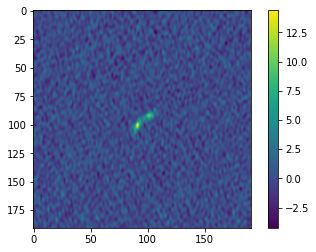

In [555]:
plt.imshow(combined[60])
plt.colorbar()

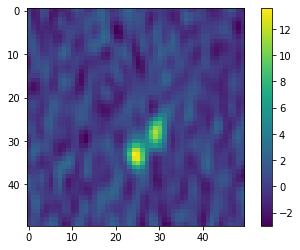

In [471]:
plt.imshow(noise_data[350:650, 1010:1060, 1010:1060][141])
plt.colorbar()

In [ ]:
np.max(noise_data[350:650, 1010:1060, 1010:1060][141]*4e-5)

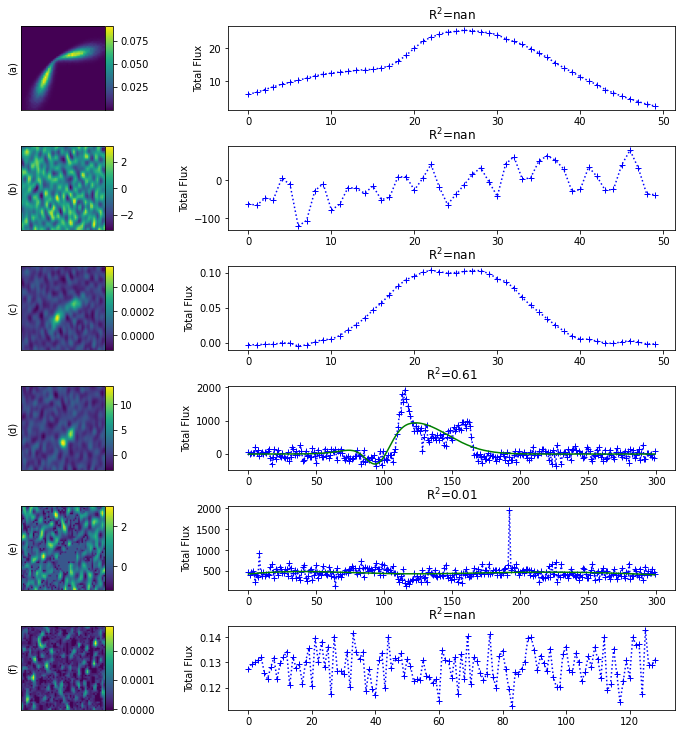

In [432]:

fig, axes = plt.subplots(6, 2, figsize=(10,10), gridspec_kw={'width_ratios': [1, 2]})
mock_gal = fits.getdata("../data/mock_gals/model1000.fits")

im1 = axes[0][0].imshow(mock_gal[90, 180:230, 180:230]) #, cmap='ds9aips0')
fit_gauss(mock_gal[65:115, 180:230, 180:230], axes[0][1])
cax1 = make_axes_locatable(axes[0][0]).append_axes("right", size="10%",pad=0)
fig.colorbar(im1, cax=cax1)

im2 = axes[1][0].imshow(em_subcube[60, 70:120, 70:120]) #, cmap='ds9aips0')
fit_gauss(em_subcube[40:90, 70:120, 70:120], axes[1][1])
cax2 = make_axes_locatable(axes[1][0]).append_axes("right", size="10%",pad=0)
fig.colorbar(im2, cax=cax2)

im3 = axes[2][0].imshow(combined[60, 70:120, 70:120]) #, cmap='ds9aips0')
fit_gauss(combined[40:90, 70:120, 70:120], axes[2][1])
cax3 = make_axes_locatable(axes[2][0]).append_axes("right", size="10%",pad=0)
fig.colorbar(im3, cax=cax3)

subcube = np.moveaxis(noise_data[350:650, 1010:1060, 1010:1060], 0, 2)
im4 = axes[3][0].imshow(subcube[...,141]) #, cmap='ds9aips0')
fit_gauss(subcube, axes[3][1])
cax4 = make_axes_locatable(axes[3][0]).append_axes("right", size="10%",pad=0)
fig.colorbar(im4, cax=cax4)

subcube[np.where(subcube > np.mean(subcube) + np.std(subcube))] = np.mean(subcube)
im5 = axes[4][0].imshow(-subcube[...,141]) #, cmap='ds9aips0')
fit_gauss(-subcube, axes[4][1])
cax5 = make_axes_locatable(axes[4][0]).append_axes("right", size="10%",pad=0)
fig.colorbar(im5, cax=cax5)

added[np.where(added > np.mean(added) + np.std(added))] = np.mean(added)
im6 = axes[5][0].imshow(-added[...,60]) #, cmap='ds9aips0')
fit_gauss(-added, axes[5][1])
cax6 = make_axes_locatable(axes[5][0]).append_axes("right", size="10%",pad=0)
fig.colorbar(im6, cax=cax6)

axes[0][0].axes.xaxis.set_visible(False)
axes[1][0].axes.xaxis.set_visible(False)
axes[2][0].axes.xaxis.set_visible(False)
axes[3][0].axes.xaxis.set_visible(False)
axes[4][0].axes.xaxis.set_visible(False)
axes[5][0].axes.xaxis.set_visible(False)


axes[0][0].set(ylabel='(a)')
plt.setp(axes[0][0].get_xticklabels(), visible=False)
plt.setp(axes[0][0].get_yticklabels(), visible=False)
axes[0][0].tick_params(axis='both', which='both', length=0)

axes[1][0].set(ylabel='(b)')
plt.setp(axes[1][0].get_xticklabels(), visible=False)
plt.setp(axes[1][0].get_yticklabels(), visible=False)
axes[1][0].tick_params(axis='both', which='both', length=0)

axes[2][0].set(ylabel='(c)')
plt.setp(axes[2][0].get_xticklabels(), visible=False)
plt.setp(axes[2][0].get_yticklabels(), visible=False)
axes[2][0].tick_params(axis='both', which='both', length=0)

axes[3][0].set(ylabel='(d)')
plt.setp(axes[3][0].get_xticklabels(), visible=False)
plt.setp(axes[3][0].get_yticklabels(), visible=False)
axes[3][0].tick_params(axis='both', which='both', length=0)

axes[4][0].set(ylabel='(e)')
plt.setp(axes[4][0].get_xticklabels(), visible=False)
plt.setp(axes[4][0].get_yticklabels(), visible=False)
axes[4][0].tick_params(axis='both', which='both', length=0)

axes[5][0].set(ylabel='(f)')
plt.setp(axes[5][0].get_xticklabels(), visible=False)
plt.setp(axes[5][0].get_yticklabels(), visible=False)
axes[5][0].tick_params(axis='both', which='both', length=0)

fig.tight_layout(pad=0.)
plt.show()

In [366]:
with open("../data_generators/cube_summaries/noise_eccentricity.txt", "rb") as fp:
    noise_eccentricity = pickle.load(fp)
with open("../data_generators/cube_summaries/noise_flatness.txt", "rb") as fp:
    noise_flatness = pickle.load(fp)
with open("../data_generators/cube_summaries/noise_peak_flux.txt", "rb") as fp:
    noise_peak_flux = pickle.load(fp)
with open("../data_generators/cube_summaries/noise_tot_flux.txt", "rb") as fp:
    noise_tot_flux = pickle.load(fp)

In [261]:
import pandas as pd

ndf_1353 = pd.DataFrame([i for i in noise_eccentricity if "1353" in i[0]], columns=[["filename", "eccentricity"]])
ndf_1353.columns = ndf_1353.columns.map(''.join)
ndf_1353["flatness"] = [i[1] for i in noise_flatness if "1353" in i[0]]
ndf_1353["peak_flux"] = [i[1] for i in noise_peak_flux if "1353" in i[0]]
ndf_1353["tot_flux"] = [i[1] for i in noise_tot_flux if "1353" in i[0]]
ndf_1353['freq_1'] = [freq_dict["mask_" + i.split(".")[0] + ".fits"][0] for i in ndf_1353.filename]
ndf_1353['freq_labels'] = ["-".join((np.round(np.array(freq_dict["mask_" + i.split(".")[0] + ".fits"])*1e-6)).astype(int).astype(str)) for i in ndf_1353.filename]
ndf_1353 = ndf_1353.sort_values('freq_1')

ndf_1245 = pd.DataFrame([i for i in noise_eccentricity if "1245" in i[0]], columns=[["filename", "eccentricity"]])
ndf_1245.columns = ndf_1245.columns.map(''.join)
ndf_1245["flatness"] = [i[1] for i in noise_flatness if "1245" in i[0]]
ndf_1245["peak_flux"] = [i[1] for i in noise_peak_flux if "1245" in i[0]]
ndf_1245["tot_flux"] = [i[1] for i in noise_tot_flux if "1245" in i[0]]
ndf_1245['freq_1'] = [freq_dict["mask_" + i.split(".")[0] + ".fits"][0] for i in ndf_1245.filename]
ndf_1245['freq_labels'] = ["-".join((np.round(np.array(freq_dict["mask_" + i.split(".")[0] + ".fits"])*1e-6)).astype(int).astype(str)) for i in ndf_1245.filename]
ndf_1245 = ndf_1245.sort_values('freq_1')


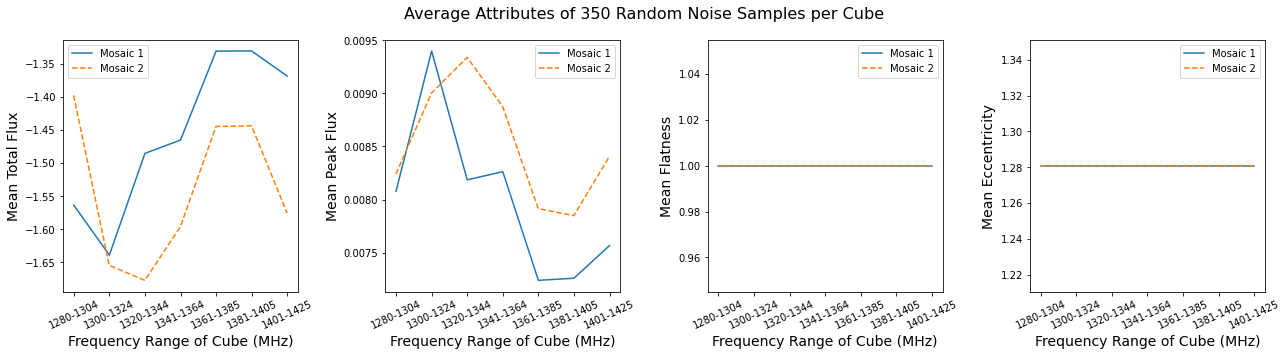

In [262]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(18, 5))

ax1.set_xlabel(r"Frequency Range of Cube (MHz)", fontsize=14)
ax1.set_xticks(ticks=ndf_1245.freq_1)
ax1.set_xticklabels(ndf_1245.freq_labels, rotation=25)
ax1.set_ylabel("Mean Total Flux", fontsize=14)
ax1.plot(ndf_1245.freq_1, ndf_1245.tot_flux, label="Mosaic 1")
ax1.plot(ndf_1353.freq_1, ndf_1353.tot_flux, label="Mosaic 2", linestyle="--")
ax1.tick_params(axis='y')
ax1.legend()

ax2.set_xlabel(r"Frequency Range of Cube (MHz)", fontsize=14)
ax2.set_xticks(ticks=ndf_1245.freq_1)
ax2.set_xticklabels(ndf_1245.freq_labels, rotation=25)
ax2.set_ylabel("Mean Peak Flux", fontsize=14)
ax2.plot(ndf_1245.freq_1, ndf_1245.peak_flux, label="Mosaic 1")
ax2.plot(ndf_1353.freq_1, ndf_1353.peak_flux, label="Mosaic 2", linestyle="--")
ax2.tick_params(axis='y')
ax2.legend()

ax3.set_xlabel(r"Frequency Range of Cube (MHz)", fontsize=14)
ax3.set_xticks(ticks=ndf_1245.freq_1)
ax3.set_xticklabels(ndf_1245.freq_labels, rotation=25)
ax3.set_ylabel("Mean Flatness", fontsize=14)
ax3.plot(ndf_1245.freq_1, ndf_1245.flatness, label="Mosaic 1")
ax3.plot(ndf_1353.freq_1, ndf_1353.flatness, label="Mosaic 2", linestyle="--")
ax3.tick_params(axis='y')
ax3.legend()

ax4.set_xlabel(r"Frequency Range of Cube (MHz)", fontsize=14)
ax4.set_xticks(ticks=ndf_1245.freq_1)
ax4.set_xticklabels(ndf_1245.freq_labels, rotation=25)
ax4.set_ylabel("Mean Eccentricity", fontsize=14)
ax4.plot(ndf_1245.freq_1, ndf_1245.eccentricity, label="Mosaic 1")
ax4.plot(ndf_1353.freq_1, ndf_1353.eccentricity, label="Mosaic 2", linestyle="--")
ax4.tick_params(axis='y')
ax4.legend()

fig.suptitle("Average Attributes of 350 Random Noise Samples per Cube", fontsize=16)
fig.tight_layout()
plt.show()

## Create examples for report

In [25]:
ds9aips0 = {'red': lambda v : np.select([v < 1/9., v < 2/9., v < 3/9., v < 4/9., v < 5/9.,
                                        v < 6/9., v < 7/9., v < 8/9., v <= 1],
                                        [0.196, 0.475, 0, 0.373, 0, 0, 1, 1, 1]), 
            'green': lambda v : np.select([v < 1/9., v < 2/9., v < 3/9., v < 4/9., v < 5/9.,
                                        v < 6/9., v < 7/9., v < 8/9., v <= 1],
                                        [0.196, 0, 0, 0.655, 0.596, 0.965, 1, 0.694, 0]),
            'blue': lambda v : np.select([v < 1/9., v < 2/9., v < 3/9., v < 4/9., v < 5/9.,
                                        v < 6/9., v < 7/9., v < 8/9., v <= 1],
                                        [0.196, 0.608, 0.785, 0.925, 0, 0, 0, 0, 0])}
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

ds9aips0 = LinearSegmentedColormap('ds9aips0', segmentdata=ds9aips0, N=256)

In [11]:
input_gal = fits.getdata("../data/training/loudInput/loud_1245mosC.fits")

input_gal[90:110, 700:1050, 130:580].shape

(20, 350, 450)

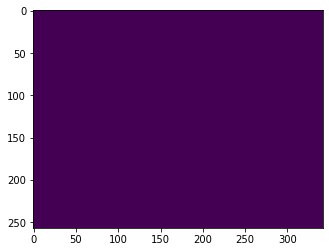

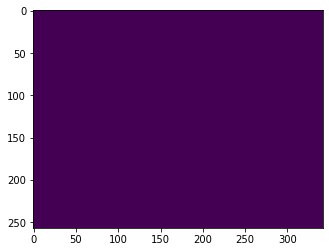

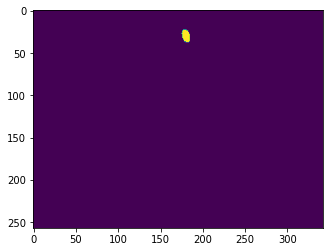

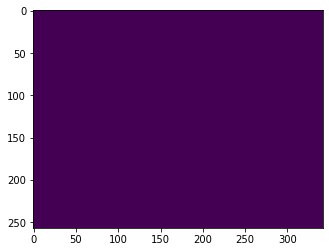

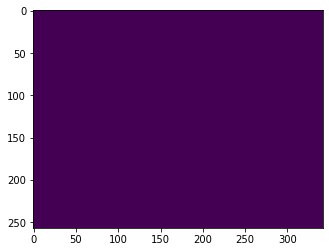

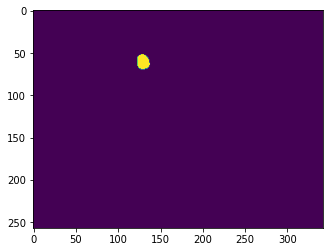

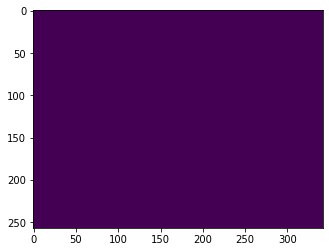

In [37]:
limits = [np.arange(0, i, int(i/7)) for i in input_gal.shape]
target_data = fits.getdata("../data/training/Target/mask_1245mosC.fits")
for i in range(7):
    subcube = target_data[limits[0][i]:limits[0][i+1], limits[1][i]:limits[1][i+1], limits[2][i]:limits[2][i+1]]
    plt.imshow(subcube[40])
    plt.show()

In [10]:
np.prod(input_gal[90:110, 700:1050, 130:580].shape)

3150000

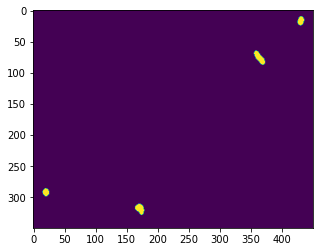

In [152]:
target_data = fits.getdata("../data/training/Target/mask_1245mosC.fits")

plt.imshow(target_data[100, 700:1050, 130:580])

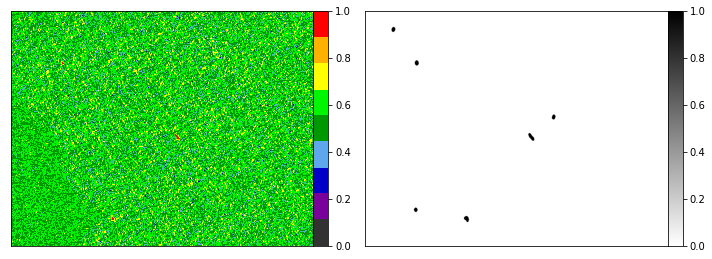

In [28]:
input_gal = fits.getdata("../data/training/loudInput/loud_1245mosC.fits")
target_data = fits.getdata("../data/training/Target/mask_1245mosC.fits")

interval = ZScaleInterval()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

im1 = ax1.imshow(interval(input_gal[100, 400:1100, :900]), cmap=ds9aips0)

im2 = ax2.imshow(target_data[100, 400:1100, :900], cmap='binary')


cax1 = make_axes_locatable(ax1).append_axes("right", size="5%",pad=0)
fig.colorbar(im1, cax=cax1)

cax2 = make_axes_locatable(ax2).append_axes("right", size="5%",pad=0)
fig.colorbar(im2, cax=cax2)
ax2.axes.xaxis.set_visible(False)
ax1.axes.xaxis.set_visible(False)
ax2.axes.yaxis.set_visible(False)
ax1.axes.yaxis.set_visible(False)
fig.tight_layout()
plt.show()

In [367]:
mock_gal = fits.getdata("../data/mock_gals/model1000.fits")
real_data = fits.getdata("../data/mosaics/1245mosC.derip.norm.fits")
interval = ZScaleInterval()

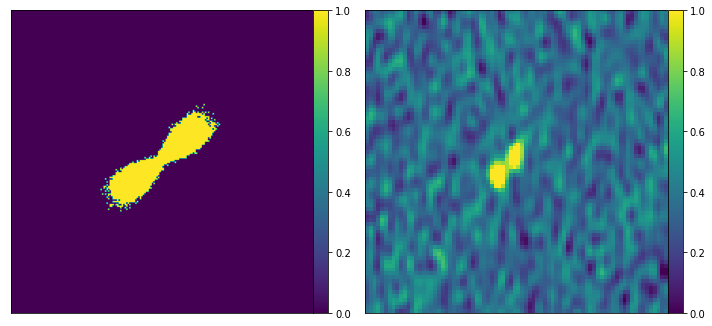

In [368]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

im1 = ax1.imshow(interval(mock_gal[100, 100:300, 100:300]), cmap='viridis')

im2 = ax2.imshow(interval(real_data[491, 1000:1080, 1000:1080]), cmap='viridis')


cax1 = make_axes_locatable(ax1).append_axes("right", size="5%",pad=0)
fig.colorbar(im1, cax=cax1)

cax2 = make_axes_locatable(ax2).append_axes("right", size="5%",pad=0)
fig.colorbar(im2, cax=cax2)
ax2.axes.xaxis.set_visible(False)
ax1.axes.xaxis.set_visible(False)
ax2.axes.yaxis.set_visible(False)
ax1.axes.yaxis.set_visible(False)
fig.tight_layout()
plt.show()

In [30]:
def anisotropic_diffusion(image, num_iters=10, K=2,  
    stepsize_lambda=0.2):
    if stepsize_lambda > 0.25:
        raise ValueError('step_size parameter must be <= 0.25 for numerical stability.')
    image = image.copy()
    # simplistic boundary conditions -- no diffusion at the boundary
    central = image[1:-1, 1:-1]
    n = image[:-2, 1:-1]
    s = image[2:, 1:-1]
    e = image[1:-1, :-2]
    w = image[1:-1, 2:]
    directions = [s,e,w]
    for i in range(num_iters):
        di = n - central
        accumulator = di/(1 + (np.absolute(di)/K)**2)
    for direction in directions:
        di = direction - central
        accumulator += di/(1 + (np.absolute(di)/K)**2)
    accumulator *= stepsize_lambda
    central += accumulator
    return image

- Find a usable tile size
 - Find an image's largest flat tile
   - Check if at least one background tile is available at this scale
   - If tiles available, double the size until a maximum is found
   - If no tiles available, halve size until flat tiles found
 - Find all flat tiles of the largest usable tile size
   - Test if tile is flat - check normality and equal means
   - Discard tiles which are entirely zeros
   - Prevents breaking where the image has e.g. borders removed
   - May result in slightly lower background estimates as partial zero tiles are not removed
   - Discard tiles which are entirely NANs
   - If tile fails to be normal, reject it
     - Test the hypothesis that the values in an array come from a normal distribution
     - If p < test_statistic -> reject null hypothesis -> values are not from a normal distribution
   - If half tile means are not equal, reject the tile
     - Test the hypothesis that two arrays have an equal mean
     - T-test assuming equal variance
     - If p < test_statistic -> reject null hypothesis -> means are not equal
 - Estimate mean and variance over usable tiles

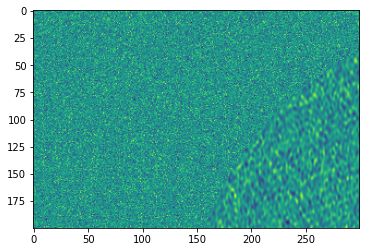

In [95]:
orig_data = fits.getdata("../data/training/loudInput/loud_1245mosC.fits")
plt.imshow(orig_data[500, :200, :300])

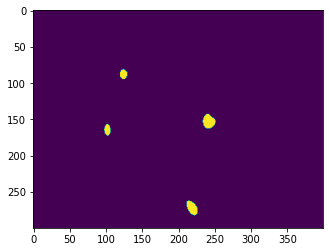

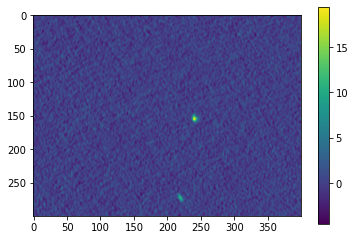

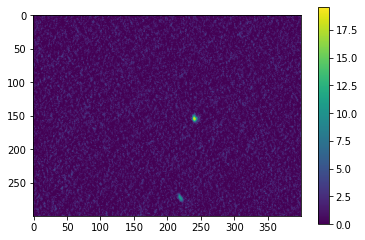

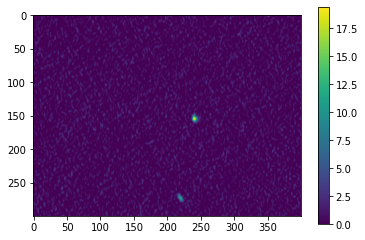

In [54]:
plt.imshow(mask_data[95])
plt.show()
plt.imshow(orig_data[95])
plt.colorbar()
plt.show()
plt.imshow(subtracted[95])
plt.colorbar()
plt.show()
plt.imshow(subtracted1[95])
plt.colorbar()
plt.show()

In [35]:
data = fits.getdata("../data/training/loudInput/loud_1245mosC.fits")

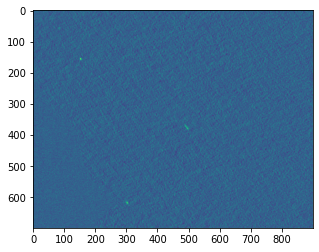

In [38]:
plt.imshow(data[100, 400:1100, :900])

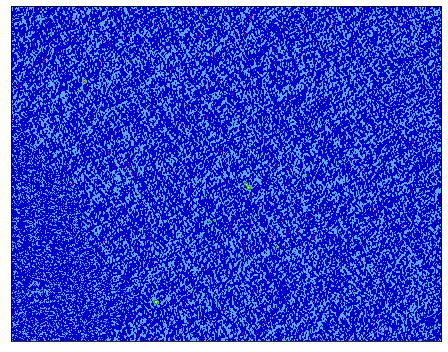

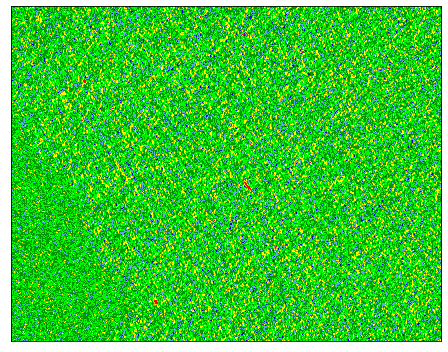

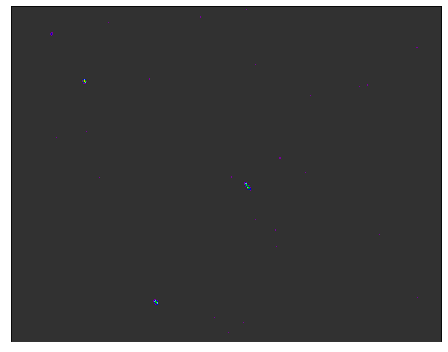

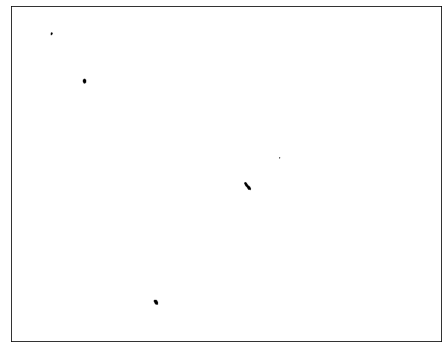

In [44]:
subcube = fits.getdata("../data/training/loudInput/loud_1245mosC.fits")[80:120, 400:1100, :900]
smoothed = ndi.gaussian_filter((subcube), sigma=0.85)
diffused = anisotropic_diffusion(smoothed, num_iters=10, K=2, stepsize_lambda=0.1)
diffused[diffused < 0] = 0

fig, ax1 = plt.subplots(figsize=(10, 5))
im1 = ax1.imshow(subcube[20], cmap=ds9aips0)
# cax1 = make_axes_locatable(ax1).append_axes("right", size="5%",pad=0)
fig.colorbar(im1, cax=cax1)
ax1.axes.xaxis.set_visible(False)
ax1.axes.yaxis.set_visible(False)
fig.tight_layout()

fig, ax1 = plt.subplots(figsize=(10, 5))
im1 = ax1.imshow(interval(subcube[20]), cmap=ds9aips0)
# cax1 = make_axes_locatable(ax1).append_axes("right", size="5%",pad=0)
fig.colorbar(im1, cax=cax1)
ax1.axes.xaxis.set_visible(False)
ax1.axes.yaxis.set_visible(False)
fig.tight_layout()

fig, ax2 = plt.subplots(figsize=(10, 5))
im2 = ax2.imshow(diffused[20], cmap=ds9aips0)
# cax2 = make_axes_locatable(ax2).append_axes("right", size="5%",pad=0)
fig.colorbar(im2, cax=cax2)
ax2.axes.xaxis.set_visible(False)
ax2.axes.yaxis.set_visible(False)
fig.tight_layout()

fig, ax2 = plt.subplots(figsize=(10, 5))
im2 = ax2.imshow((diffused > 2)[20], cmap='binary')
# cax2 = make_axes_locatable(ax2).append_axes("right", size="5%",pad=0)
fig.colorbar(im2, cax=cax2)
ax2.axes.xaxis.set_visible(False)
ax2.axes.yaxis.set_visible(False)
fig.tight_layout()

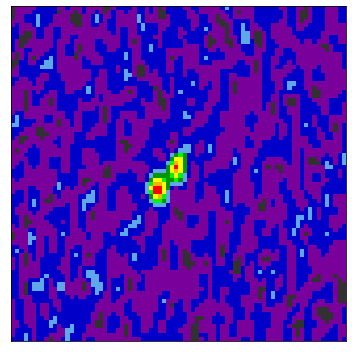

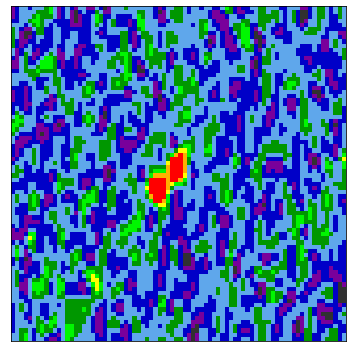

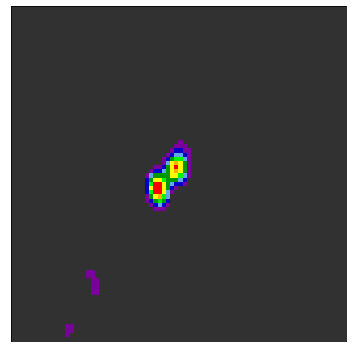

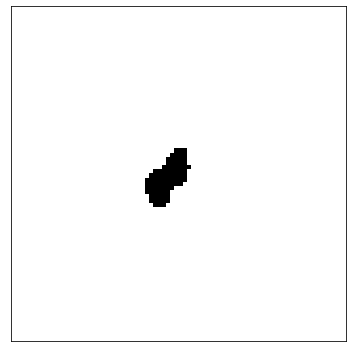

In [31]:
subcube = fits.getdata("../data/mosaics/1245mosC.derip.norm.fits")[471:511, 1000:1080, 1000:1080]
smoothed = ndi.gaussian_filter((subcube), sigma=0.85)
diffused = anisotropic_diffusion(smoothed)
diffused[diffused < 0] = 0

fig, ax1 = plt.subplots(figsize=(10, 5))
im1 = ax1.imshow(subcube[20], cmap=ds9aips0)
# cax1 = make_axes_locatable(ax1).append_axes("right", size="5%",pad=0)
fig.colorbar(im1, cax=cax1)
ax1.axes.xaxis.set_visible(False)
ax1.axes.yaxis.set_visible(False)
fig.tight_layout()

fig, ax1 = plt.subplots(figsize=(10, 5))
im1 = ax1.imshow(interval(subcube[20]), cmap=ds9aips0)
# cax1 = make_axes_locatable(ax1).append_axes("right", size="5%",pad=0)
fig.colorbar(im1, cax=cax1)
ax1.axes.xaxis.set_visible(False)
ax1.axes.yaxis.set_visible(False)
fig.tight_layout()

fig, ax2 = plt.subplots(figsize=(10, 5))
im2 = ax2.imshow(diffused[20], cmap=ds9aips0)
# cax2 = make_axes_locatable(ax2).append_axes("right", size="5%",pad=0)
fig.colorbar(im2, cax=cax2)
ax2.axes.xaxis.set_visible(False)
ax2.axes.yaxis.set_visible(False)
fig.tight_layout()

fig, ax2 = plt.subplots(figsize=(10, 5))
im2 = ax2.imshow((diffused > 2)[20], cmap='binary')
# cax2 = make_axes_locatable(ax2).append_axes("right", size="5%",pad=0)
fig.colorbar(im2, cax=cax2)
ax2.axes.xaxis.set_visible(False)
ax2.axes.yaxis.set_visible(False)
fig.tight_layout()

In [61]:
input_gal = fits.getdata("../data/training/loudInput/loud_1245mosC.fits")
target_data = fits.getdata("../data/training/Target/mask_1245mosC.fits")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

im1 = ax1.imshow(interval(input_gal[100, 1100:1600, 600:1300]), cmap=ds9aips0)

im2 = ax2.imshow(target_data[100, 1100:1600, 600:1300], cmap='binary')


# cax1 = make_axes_locatable(ax1).append_axes("right", size="5%",pad=0)
# fig.colorbar(im1, cax=cax1)

# cax2 = make_axes_locatable(ax2).append_axes("right", size="5%",pad=0)
# fig.colorbar(im2, cax=cax2)
ax2.axes.xaxis.set_visible(False)
ax1.axes.xaxis.set_visible(False)
ax2.axes.yaxis.set_visible(False)
ax1.axes.yaxis.set_visible(False)
fig.tight_layout(pad=0)
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '../data/training/Input/loud_1245mosC.fits'